<a href="https://colab.research.google.com/github/alee103/grade-project/blob/main/grades_pandemic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Influence of the COVID-19 pandemic on grades**


The goal of this project is to investigate the influence of the COVID-19 pandemic on grade distributions for a university class spanning 6 semesters.

###-DATA
Grades for a large, undergraduate intro level course over six semesters: Spring 2019 to Fall 2021. These semesters span from pre-pandemic (SP19 & FA19) to pandemic (SP20-FA21).

###-RESEARCH QUESTIONS

-Q: did the pandemic have an influence on grade distributions?
  
  -A: seems so, but only for SP20

-Q: did variance of a each student's grade throughout a semester increase during pandemic (semester-on-semester)? -A:

-Q: machine learning model for predicting final grade? Which features were most important?

-Q: How were enrollment counts and number of people who dropped the class influenced? 

-A:

-others?

###-STRUCTURE


###-METHODS



# **0. Preprocess Data**

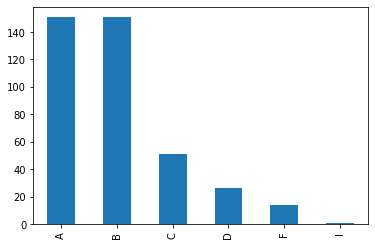

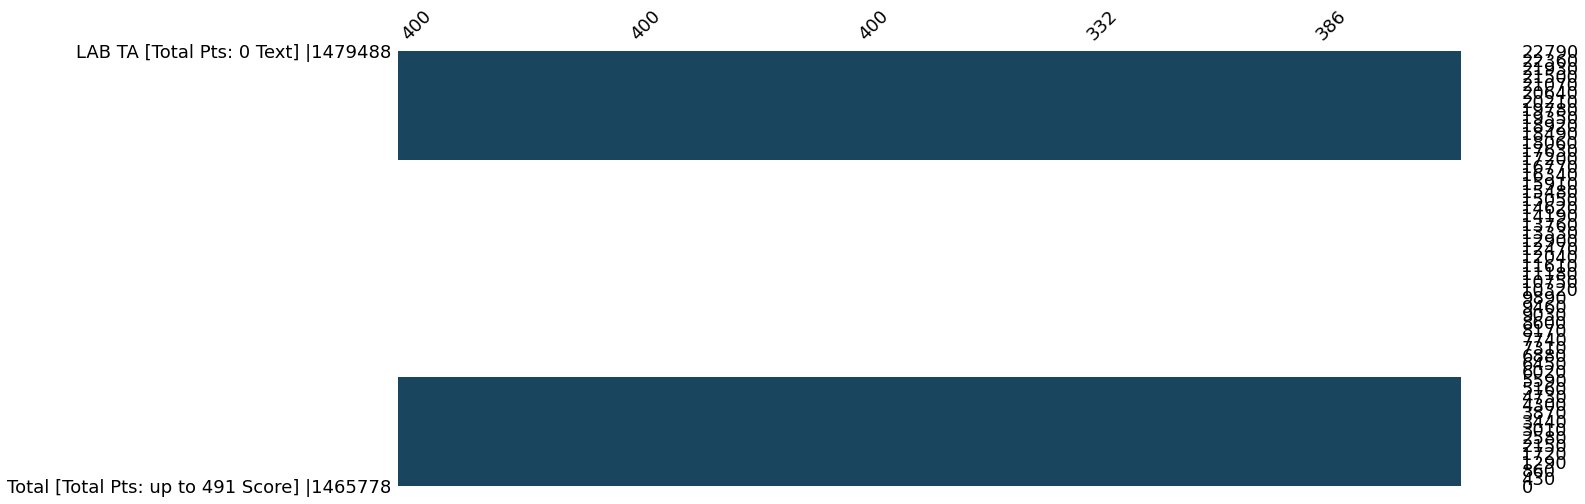

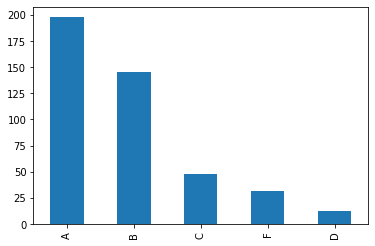

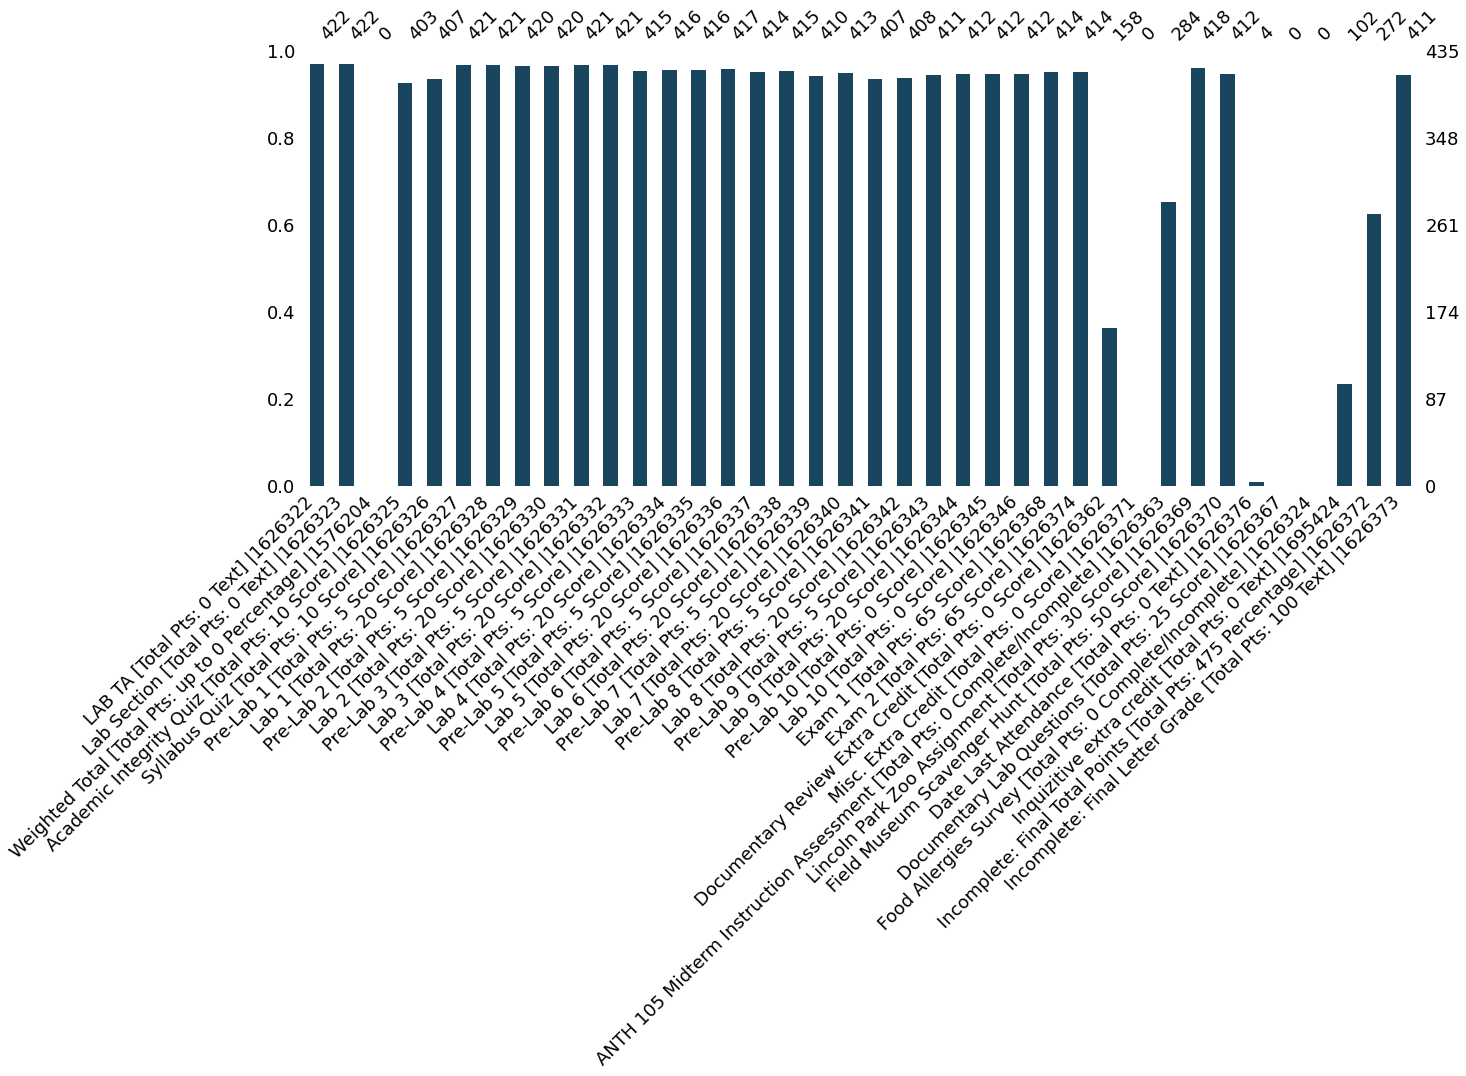

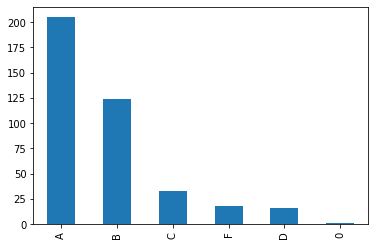

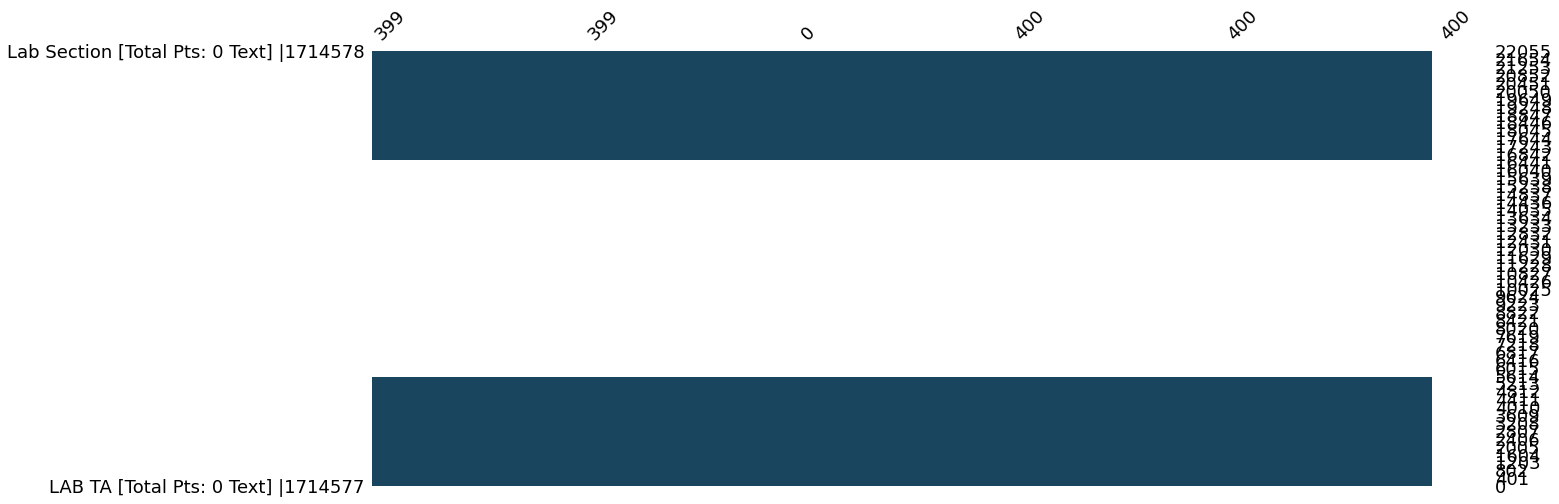

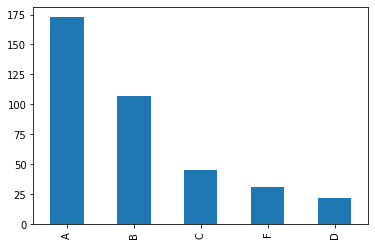

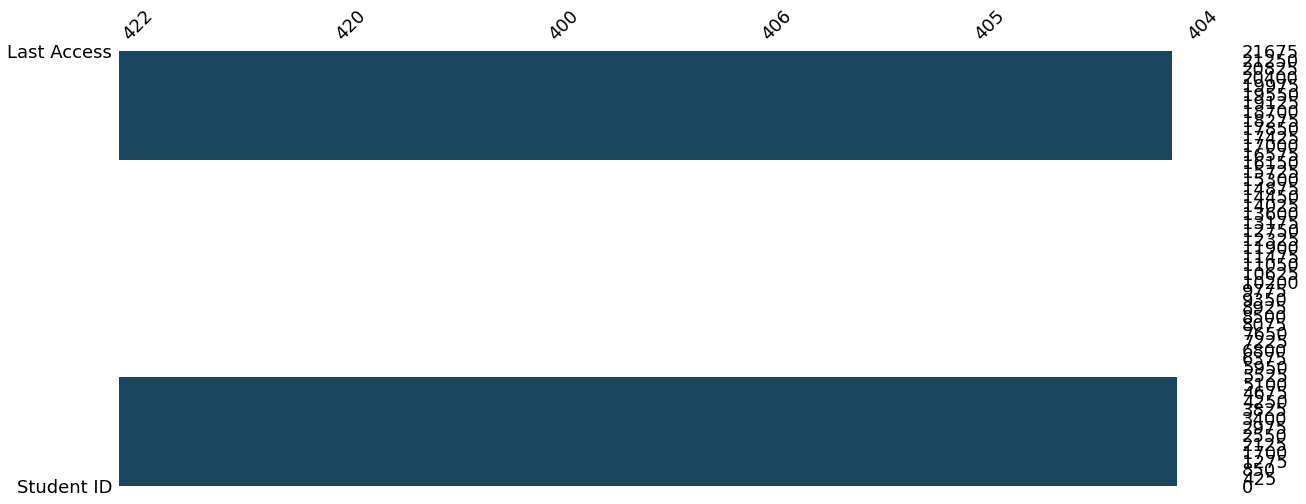

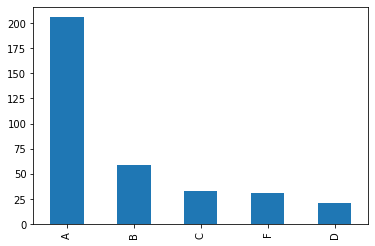

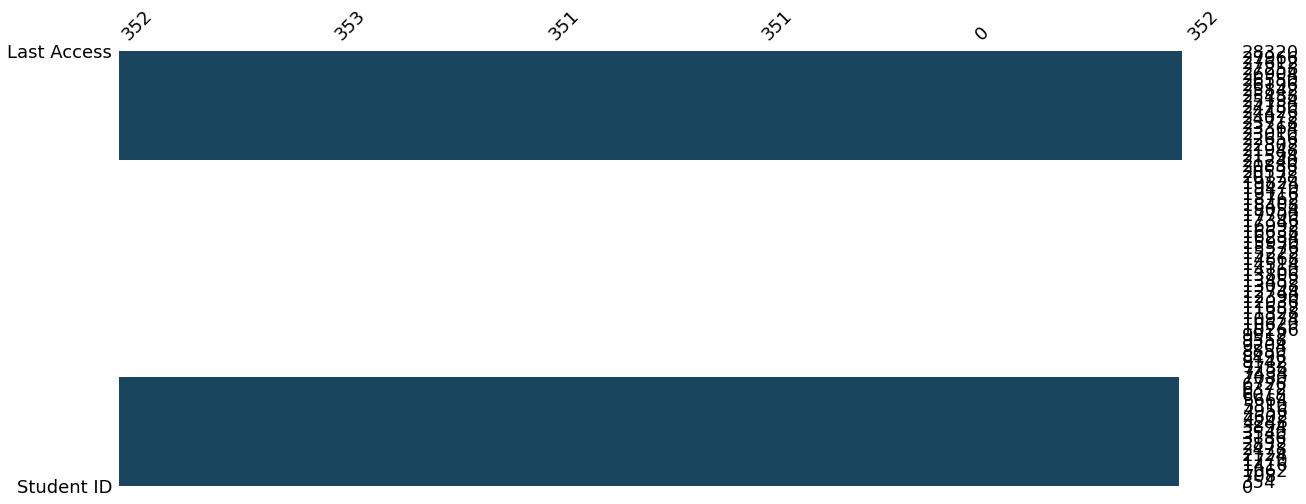

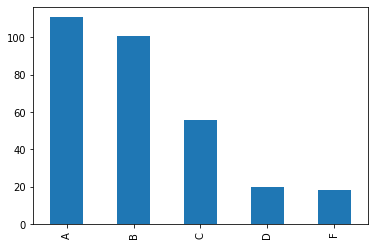

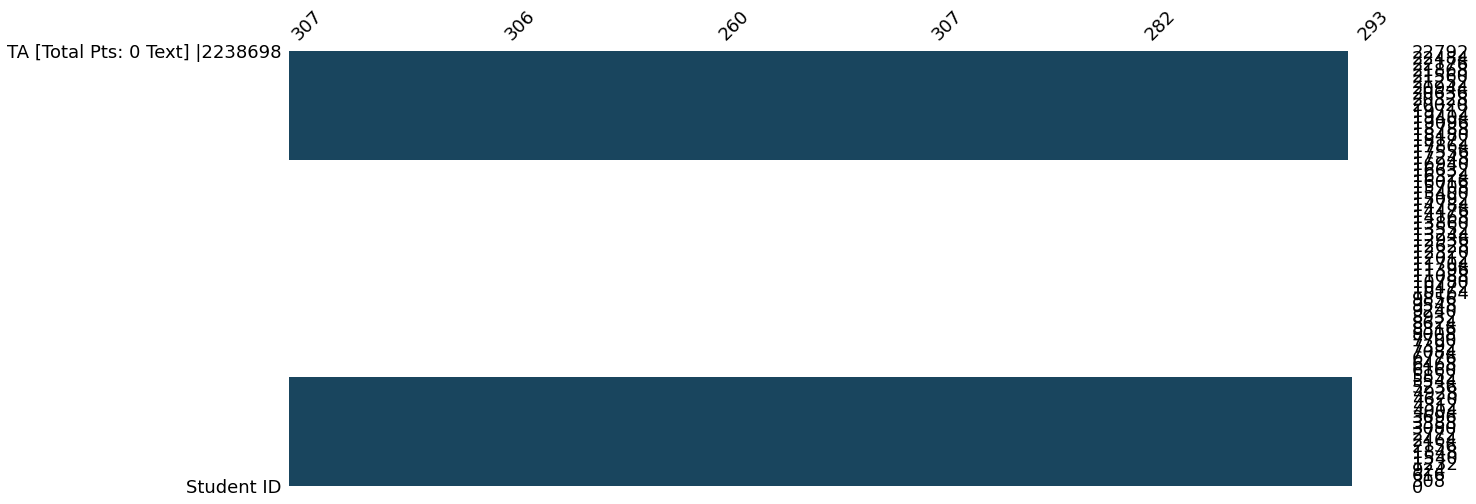

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import math
import colorcet as cc
from numpy import linspace
from scipy.stats.kde import gaussian_kde
from scipy.stats import ks_2samp

pd.set_option('display.max_rows', 500)

# Define semester labels and midterm grade columns
semester_list = ['SP19', 'FA19', 'SP20', 'FA20', 'SP21', 'FA21']
midterm_cols = np.array([[45, 46],[34, 35],[36, 37],[37, 38],[79, 80],[80, 79]])
final_cols = np.array([[53, 54],[45, 46],[40, 41],[55, 56],[83, 84],[76, 75]])

## Load datasets into dictionaries (using semester_list):
# -) Store all data in dictionary fulldata_dict (done)
# -) Anonymize date (done)
# -) Normalize data to 0-100 (TO DO)
# -) Store midterm data in dictionary midterm_dict (done)
# -) Deal with missing data (TO DO)
fulldata_dict = {}
midterm_dict = {}
final_dict = {}
mid_and_final_dict = {}
complete_mid_and_final = pd.DataFrame()

# explore missing data

fig1, axes1 = plt.subplots(2,3, figsize=(15, 6), facecolor='w', edgecolor='k')
fig2, axes2 = plt.subplots(2,3, figsize=(15, 6), facecolor='w', edgecolor='k')

# fig, axes = plt.subplots(3, 2)

# """ Iterate column's axes"""
# def iterate_columns(cols, x):
#    for col in cols:
#       col.plot(x, color='red')

# """ Iterate row's axes"""
# for row in axes1:
#    x = np.random.normal(0, 1, 100).cumsum()
#    iterate_columns(row, x)



for index, semester in enumerate(semester_list):

    # read data
    filename_str = 'Complete_' + semester + '.csv'
    fulldata_dict[semester] = pd.read_csv(filename_str)

    # anonymize 
    fulldata_dict[semester] = fulldata_dict[semester].sample(frac=1).reset_index(drop=True)
    final_dict[semester] = fulldata_dict[semester].iloc[:,final_cols[index,]]

    # visualize what data looks like
    plt.figure()
    pp = pd.value_counts(final_dict[semester].iloc[:,1])
    pp.plot.bar()

    plt.show()

    # visualize missing data
    cols_missing_val_train = fulldata_dict[semester].columns[fulldata_dict[semester].isnull().any()].tolist()
    msno.bar(fulldata_dict[semester][cols_missing_val_train],figsize=(20,8),color="#19455e",fontsize=18,labels=True,)

    plt.show()
  

### **Import modules, load packages**

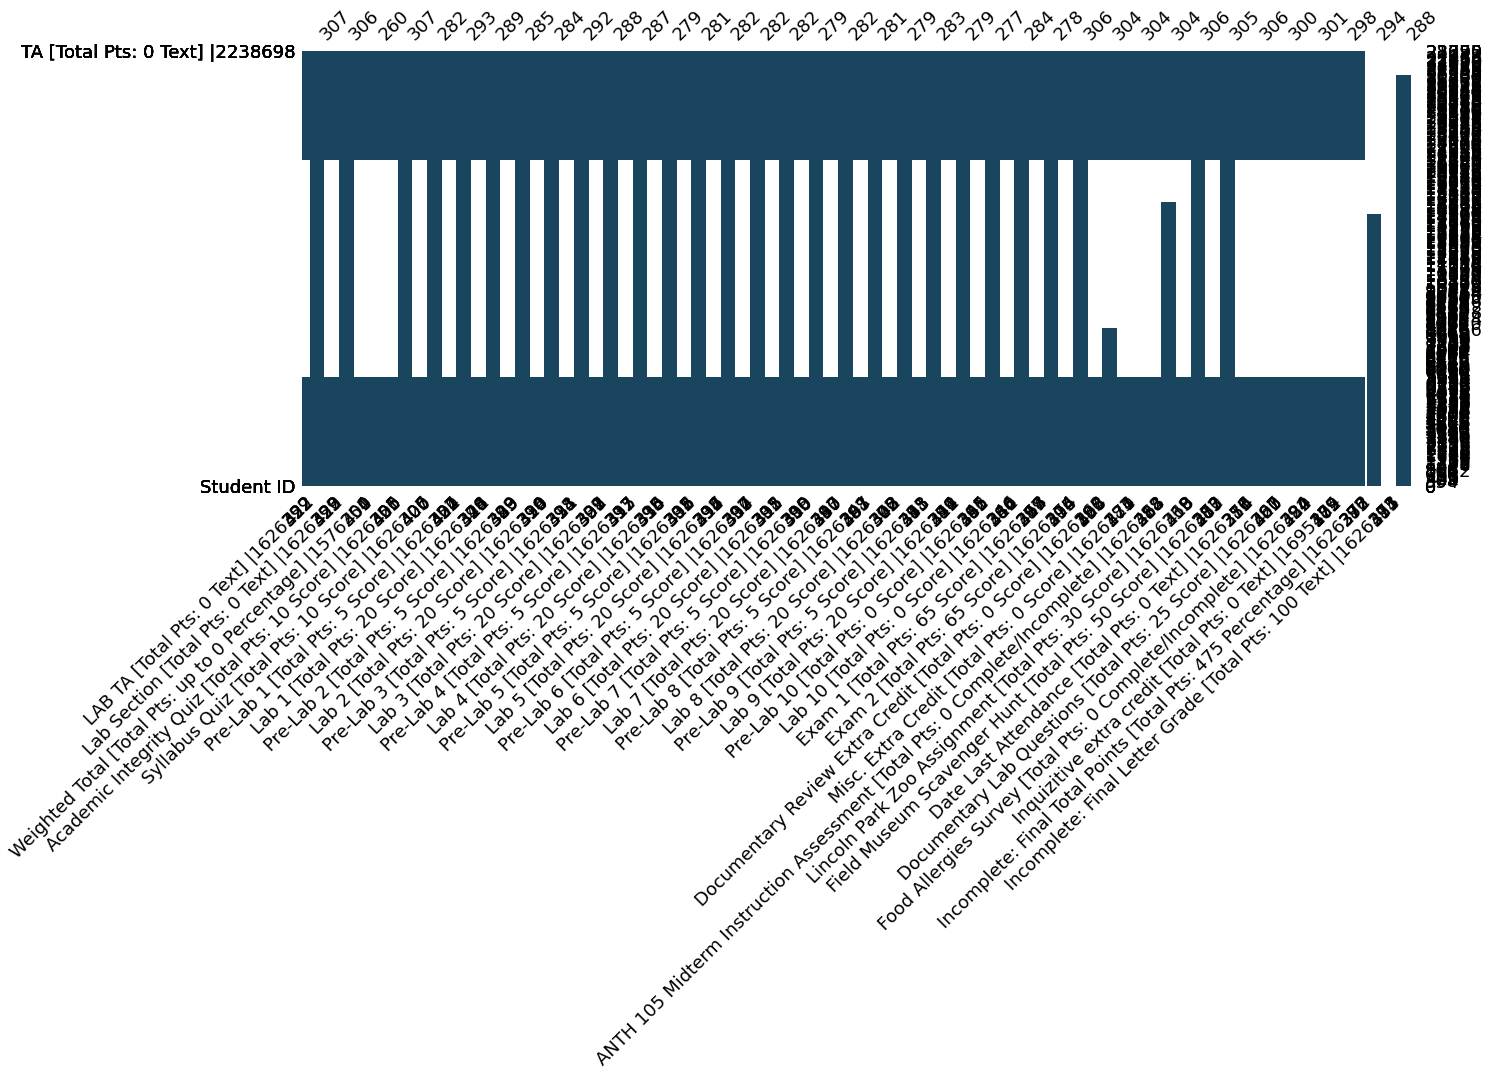

In [ ]:
import math
import colorcet as cc
from numpy import linspace
from scipy.stats.kde import gaussian_kde
from scipy.stats import ks_2samp

for index, semester in enumerate(semester_list):
    
    # handle missing data: remove rows with zeroes or NaNs in the grade columns
    fulldata_dict[semester] = fulldata_dict[semester].loc[fulldata_dict[semester].iloc[:,midterm_cols[index,0]] > 0.0001]
    fulldata_dict[semester].dropna(subset=[fulldata_dict[semester].columns[midterm_cols[index,0]],fulldata_dict[semester].columns[midterm_cols[index,1]]], how = 'any', inplace = True)

    fulldata_dict[semester] = fulldata_dict[semester].loc[fulldata_dict[semester].iloc[:,final_cols[index,0]] > 0.0001]
    fulldata_dict[semester].dropna(subset=[fulldata_dict[semester].columns[final_cols[index,0]],fulldata_dict[semester].columns[final_cols[index,1]]], how = 'any', inplace = True)

    # normalize
    mask_midterm = fulldata_dict[semester].iloc[:,midterm_cols[index,0]] > 100
    fulldata_dict[semester].iloc[mask_midterm, midterm_cols[index,[0]]] = 100

    mask_final = fulldata_dict[semester].iloc[:,final_cols[index,0]] > 100
    fulldata_dict[semester].iloc[mask_final, final_cols[index,[0]]] = 100

    # remove student who received an 'incomplete' 
    fulldata_dict[semester] = fulldata_dict[semester].loc[(fulldata_dict[semester].iloc[:,final_cols[index,1]] != 'I')]

    # extract midterm grade data
    midterm_dict[semester] = fulldata_dict[semester].iloc[:,midterm_cols[index,]]

    # extract final grade data
    final_dict[semester] = fulldata_dict[semester].iloc[:,final_cols[index,]]

    # rename columns
    midterm_dict[semester].columns = ['Midterm Percentage', 'Midterm Letter']
    final_dict[semester].columns = ['Final Percentage', 'Final Letter']

    # merge midterm and final data
    frames = [midterm_dict[semester], final_dict[semester]]
    mid_and_final_dict[semester] = pd.concat(frames, axis=1, join='inner')

    # add semester column
    mid_and_final_dict[semester].insert(0,'Semester', semester)

    # put them all together
    complete_mid_and_final = pd.concat([complete_mid_and_final, mid_and_final_dict[semester]], ignore_index=True)

    # print(midterm_dict[semester].info())
    # print(mid_and_final_dict[semester].info())
    # print(mid_and_final_dict[semester].head())


# col_lbl = fulldata_dict[semester].columns[midterm_cols[index,1]]
# fulldata_dict[semester] = fulldata_dict[semester].dropna(subset=[col_lbl])  # subset wants the name of the column, to get this we use the .columns method


# **1. Plot data and compare distributions**

### **Histograms**

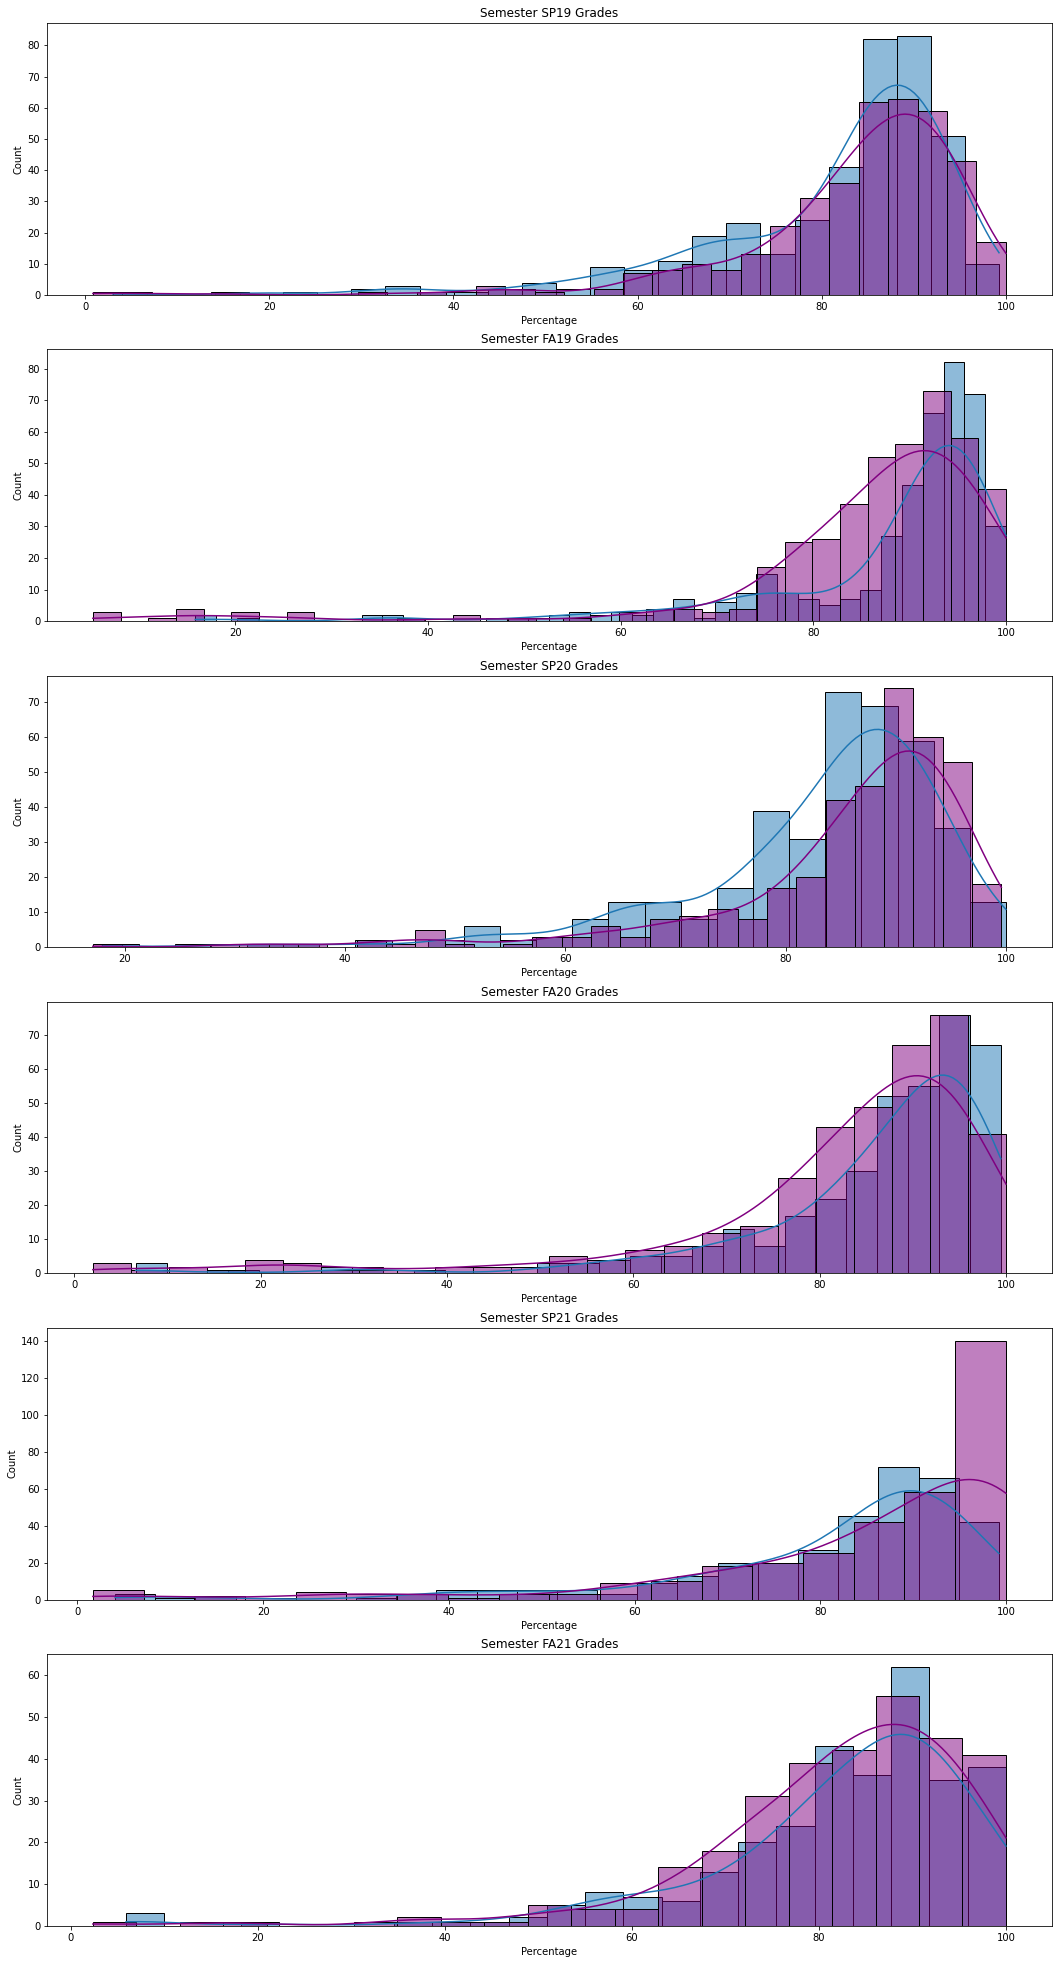

A    206
B     59
C     33
F     28
D     21
Name: Final Letter, dtype: int64


In [ ]:
fig, axes = plt.subplots(6)
fig.set_size_inches(18, 35, forward=True)

for index, semester in enumerate(semester_list):
    sns.histplot(midterm_dict[semester].iloc[:,0], kde=True, ax=axes[index]).set(title='Semester' + ' ' + semester + ' ' + 'Grades', xlabel='Percentage')
    sns.histplot(final_dict[semester].iloc[:,0], kde=True, ax=axes[index], color = "purple")

plt.show()

print(final_dict['SP21'].iloc[:,1].value_counts())

### **Ridge plot**

<Figure size 2280x1520 with 0 Axes>

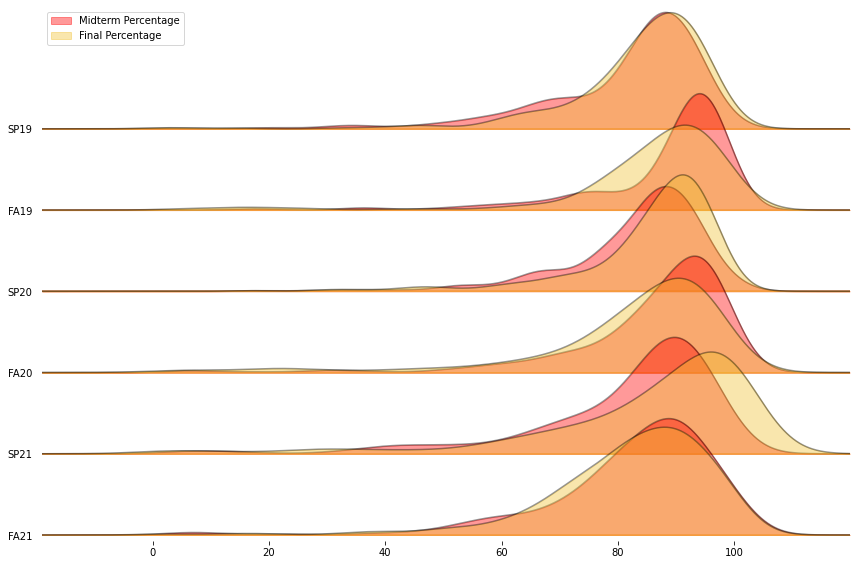

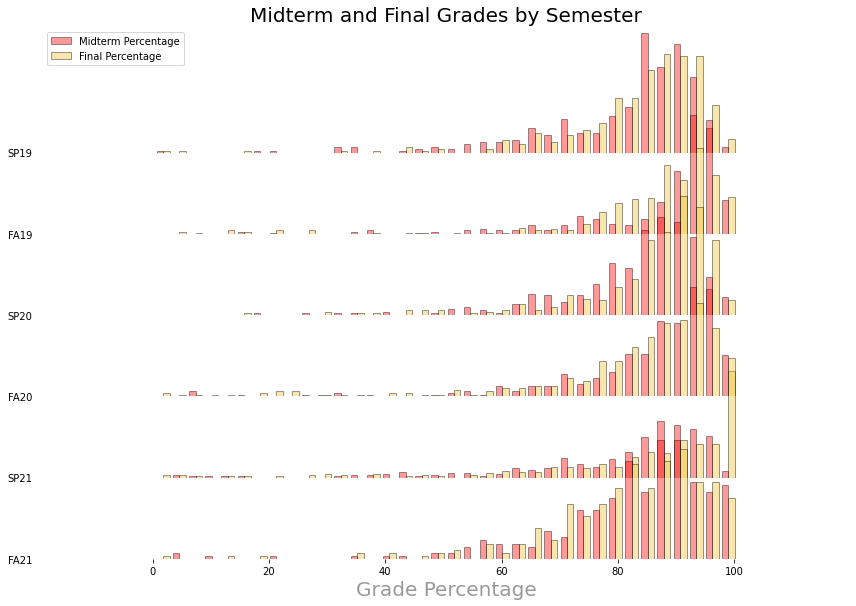

In [ ]:
!pip install joypy
import joypy

# with joypy
plt.figure(dpi= 380)

grouped = complete_mid_and_final.groupby("Semester", sort=False)
fig1, axes1 = joypy.joyplot(grouped, column=['Midterm Percentage', 'Final Percentage'], ylim='own', figsize=(12,8), color=['red', '#f1c232'], legend = True, alpha=0.4)
fig2, axes2 = joypy.joyplot(grouped, column=['Midterm Percentage', 'Final Percentage'], hist=True, bins=50, ylim='own', figsize=(12,8), color=['red', '#f1c232'], legend = True, alpha=0.4)

# adding labels
plt.title('Midterm and Final Grades by Semester', fontsize=20, color='k', alpha=1)
plt.rc("font", size=10)
plt.xlabel('Grade Percentage',  fontsize=20, alpha=0.4)
axes1[0].legend(loc = "upper left")
axes2[0].legend(loc = "upper left")

plt.show()


# # with seaborn
# sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# # Initialize the FacetGrid object
# pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
# g = sns.FacetGrid(complete_mid_and_final, row="Semester", hue="Semester", aspect=15, height=.5, palette=pal)

# # Draw the densities in a few steps
# g.map(sns.kdeplot, 'Final Percentage',
#       bw_adjust=.5, clip_on=False,
#       fill=True, alpha=1, linewidth=1.5)
# g.map(sns.kdeplot, 'Final Percentage', clip_on=False, color="w", lw=2, bw_adjust=.5)

# # passing color=None to refline() uses the hue mapping
# g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# # Define and use a simple function to label the plot in axes coordinates
# def label(x, color, label):
#     ax = plt.gca()
#     ax.text(0, .2, label, fontweight="bold", color=color,
#             ha="left", va="center", transform=ax.transAxes)


# g.map(label, 'Final Percentage')

# # Set the subplots to overlap
# g.figure.subplots_adjust(hspace=-.25)

# # Remove axes details that don't play well with overlap
# g.set_titles("")
# g.set(yticks=[], ylabel="")
# g.despine(bottom=True, left=True)
# g.fig.tight_layout()



### **KS Tests of midterm and final grades within semesters**

KS for final and midterm grades SP19: 
 Ks_2sampResult(statistic=0.09438775510204081, pvalue=0.06081251704326559)
The distributions are not significantly different


KS for final and midterm grades FA19: 
 Ks_2sampResult(statistic=0.2127659574468085, pvalue=8.52892291830149e-09)
The distributions are significantly different


KS for final and midterm grades SP20: 
 Ks_2sampResult(statistic=0.18686868686868688, pvalue=1.852443796171999e-06)
The distributions are significantly different


KS for final and midterm grades FA20: 
 Ks_2sampResult(statistic=0.15649867374005305, pvalue=0.0001904821568006381)
The distributions are significantly different


KS for final and midterm grades SP21: 
 Ks_2sampResult(statistic=0.2910662824207493, pvalue=2.324355158274044e-13)
The distributions are significantly different


KS for final and midterm grades FA21: 
 Ks_2sampResult(statistic=0.058823529411764705, pvalue=0.6657765842348662)
The distributions are not significantly different


[[0. 1. 1. 1. 1

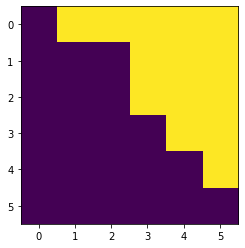

In [ ]:
# conduct two-sample KS tests within semesters
class bcolors:
    OKGREEN = '\033[92m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'

for index, semester in enumerate(semester_list):
    ks_semesters = ks_2samp(midterm_dict[semester].iloc[:,0], final_dict[semester].iloc[:,0])
    print('KS for final and midterm grades' + ' ' + semester + ': \n', ks_semesters)
    if ks_semesters[1] < 0.05:
      print(f"{bcolors.FAIL}{bcolors.BOLD}The distributions are significantly different{bcolors.ENDC}")
    else:
      print(f"{bcolors.OKGREEN}The distributions are not significantly different{bcolors.ENDC}")
    print('\n')

### **Violin Plots of Final Grades by Semester**

  Semester  Midterm Percentage Midterm Letter  Final Percentage Final Letter
0     SP19            83.83458              B          79.47368            B
1     SP19            92.85714              A          90.00000            A
2     SP19            76.69172              C          71.36842            C
3     SP19            92.10526              A         100.00000            A
4     SP19            84.21052              B          80.52631            B


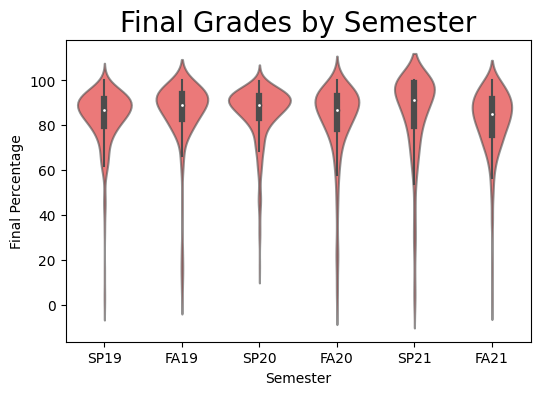

In [ ]:
plt.figure(dpi= 100)
ax = sns.violinplot(x = "Semester", y = "Final Percentage", data = complete_mid_and_final, color = "red")
for violin, alpha in zip(ax.collections[::2], [0.6,0.6,0.6,0.6,0.6,0.6]):
    violin.set_alpha(alpha)
plt.title('Final Grades by Semester', fontsize=20, color='k', alpha=1)

print(complete_mid_and_final.head())


### **KS Tests of final grades between semesters**

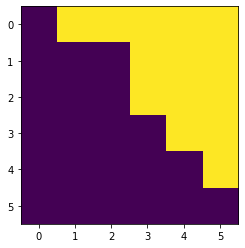

In [ ]:
data_matrix = np.zeros(shape=(len(semester_list),len(semester_list)))
for index, semester in enumerate(semester_list):
    for index_compare in range(index+1, len(semester_list)):
        ks2_test = ks_2samp(final_dict[semester].iloc[:,0], final_dict[semester_list[index_compare]].iloc[:,0])[1]  # [1] means take second output
        if ks2_test < 0.05:
            data_matrix[index, index_compare] = 1
        else:
            data_matrix[index, index_compare] = 0
        # print('index: ' + str(index))
        # print('index_compare: ' + str(index_compare))

plt.imshow(data_matrix)

### **Letter grade counts by semester**

{'Semester': ['SP19', 'FA19', 'SP20', 'FA20', 'SP21', 'FA21'], 'A': [151, 198, 205, 173, 206, 111], 'B': [151, 145, 124, 107, 59, 101], 'C': [50, 48, 33, 45, 33, 56], 'D': [25, 12, 16, 22, 21, 20], 'F': [14, 20, 18, 30, 28, 18]}


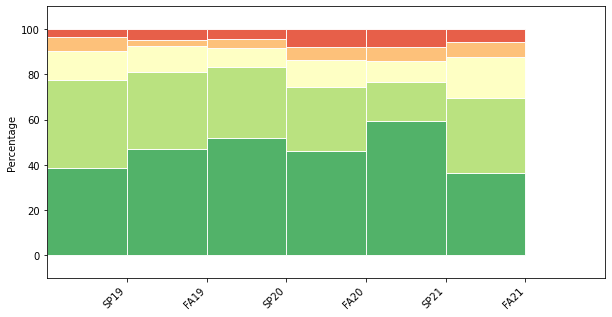

In [ ]:
# construct dataframe using list comprehensions on each letter grade
letter_grades_counts = {'Semester': semester_list,
                 'A': [np.count_nonzero(final_dict[semester].iloc[:,1].values == 'A') for semester in semester_list],
                 'B': [np.count_nonzero(final_dict[semester].iloc[:,1].values == 'B') for semester in semester_list],
                 'C': [np.count_nonzero(final_dict[semester].iloc[:,1].values == 'C') for semester in semester_list],
                 'D': [np.count_nonzero(final_dict[semester].iloc[:,1].values == 'D') for semester in semester_list],
                 'F': [np.count_nonzero(final_dict[semester].iloc[:,1].values == 'F') for semester in semester_list],
                 }

print(letter_grades_counts)

# Create a figure with a single subplot
f, ax = plt.subplots(1, figsize=(10,5))

# Set bar width at 1
bar_width = 1

# positions of the left bar-boundaries
bar_l = [i for i in range(len(letter_grades_counts['A']))] 

# positions of the x-axis ticks (center of the bars as bar labels)
tick_pos = [i+(bar_width/2) for i in bar_l] 

# Create the total score for each participant
totals = [i+j+k+l+m for i,j,k,l,m in zip(letter_grades_counts['A'], letter_grades_counts['B'], letter_grades_counts['C'], letter_grades_counts['D'], letter_grades_counts['F'])]

A_grade = [i / j * 100 for  i,j in zip(letter_grades_counts['A'], totals)]
B_grade = [i / j * 100 for  i,j in zip(letter_grades_counts['B'], totals)]
C_grade = [i / j * 100 for  i,j in zip(letter_grades_counts['C'], totals)]
D_grade = [i / j * 100 for  i,j in zip(letter_grades_counts['D'], totals)]
F_grade = [i / j * 100 for  i,j in zip(letter_grades_counts['F'], totals)]

# Create a bar chart in position bar_1
ax.bar(bar_l, 
       # using pre_rel data
       A_grade, 
       # labeled 
       label='A', 
       # with alpha
       alpha=0.9, 
       # with color
       color='#3FAA59',
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )

# Create a bar chart in position bar_1
ax.bar(bar_l, 
       # using mid_rel data
       B_grade, 
       # with pre_rel
       bottom=A_grade, 
       # labeled 
       label='B', 
       # with alpha
       alpha=0.9, 
       # with color
       color='#B3DF72', 
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )

# Create a bar chart in position bar_1
ax.bar(bar_l, 
       # using post_rel data
       C_grade, 
       # with pre_rel and mid_rel on bottom
       bottom=[i+j for i,j in zip(A_grade, B_grade)], 
       # labeled 
       label='C',
       # with alpha
       alpha=0.9, 
       # with color
       color='#FEFFBE', 
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )

# Create a bar chart in position bar_1
ax.bar(bar_l, 
       # using post_rel data
       D_grade, 
       # with pre_rel and mid_rel on bottom
       bottom=[i+j+k for i,j,k in zip(A_grade, B_grade, C_grade)], 
       # labeled 
       label='D',
       # with alpha
       alpha=0.9, 
       # with color
       color='#FDBB6C', 
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )

# Create a bar chart in position bar_1
ax.bar(bar_l, 
       # using post_rel data
       F_grade, 
       # with pre_rel and mid_rel on bottom
       bottom=[i+j+k+l for i,j,k,l in zip(A_grade, B_grade, C_grade, D_grade)], 
       # labeled 
       label='F',
       # with alpha
       alpha=0.9, 
       # with color
       color='#E54E35', 
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )

# Set the ticks to be first names
plt.xticks(tick_pos, letter_grades_counts['Semester'])
ax.set_ylabel("Percentage")
ax.set_xlabel("")

# Let the borders of the graphic
plt.xlim([min(tick_pos)-bar_width, max(tick_pos)+bar_width])
plt.ylim(-10, 110)

# rotate axis labels
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')

# shot plot
plt.show()

# **Machine Learning Model**

### **Reshape data**

In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer

# define features and target variable
X_cols = np.array([range(58,62),range(47,51),range(60,64),range(57,61),range(88,92),range(84, 88)])
y_cols = np.array([[54],[46],[41],[56],[84],[75]])

X_dict = {}
y_dict = {}
X = pd.DataFrame()
y = pd.DataFrame()

for index, semester in enumerate(semester_list):

    # extract feature data
    X_dict[semester] = fulldata_dict[semester].iloc[:,X_cols[index,]]

    # extract target data
    y_dict[semester] = fulldata_dict[semester].iloc[:,y_cols[index,]]

    # convert "Total Extra Credit" to binary (completed (True) vs. not completed (False)) and add it as a new column
    for row_idx in range(X_dict[semester].shape[0]):
        if X_dict[semester].iloc[row_idx,3] > 0:
            X_dict[semester]['Extra Credit'] = True
        else:
            X_dict[semester]['Extra Credit'] = False

    # delete old extra credit column
    X_dict[semester].drop(X_dict[semester].columns[[3]], axis = 1, inplace = True)

    # rename columns
    X_dict[semester].columns = ['Assignments', 'Exams','Attendance', 'Extra Credit']
    y_dict[semester].columns = ['Final Letter Grade']

    # put all semesters together
    X = pd.concat([X, X_dict[semester]], ignore_index=True)
    y = pd.concat([y, y_dict[semester]], ignore_index=True)

# label_encoder object
label_encoder = LabelEncoder()
# Encode labels in column. 
y['Final Letter Grade']= label_encoder.fit_transform(y['Final Letter Grade'])

print(y.value_counts())
print(y.head(10))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

Final Letter Grade
0                     1044
1                      687
2                      265
4                      128
3                      116
dtype: int64
   Final Letter Grade
0                   0
1                   2
2                   0
3                   0
4                   0
5                   0
6                   1
7                   2
8                   2
9                   0


### **Random forest modelling**

In [ ]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn import utils
from sklearn.metrics import r2_score

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

lab_enc = preprocessing.LabelEncoder()
encoded = lab_enc.fit_transform(y_train)

print(utils.multiclass.type_of_target(y_train))

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

score=r2_score(y_test,y_pred)

print("Accuracy for our testing dataset using RandomForestClassifier is : {:.3f}%".format(score*100) )

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


multiclass
Accuracy for our testing dataset using RandomForestClassifier is : 80.458%


### **Feature Importance with SHAP**

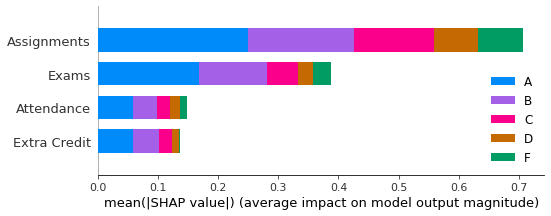

In [ ]:
from sklearn.inspection import permutation_importance
! pip install shap
import shap
from matplotlib import pyplot as plt

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)

grade_labels = ['A','B','C','D','F']

shap.summary_plot(shap_values, X_test, plot_type="bar", class_names = grade_labels, title="Feature Importance with SHAP")